<h1 align="center">Spanish high speed rail ticket price prediction</h1>
<h2 align="center">(Advanced data science IBM specialization - capstone project)</h2>

### Model training and evaluation

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import Callback

%matplotlib inline

Using TensorFlow backend.


#### Run next cell only if catboost installation needed!

In [ ]:
!pip install catboost

In [2]:
from catboost import Pool, CatBoostRegressor

In [3]:
# Download prepared data 

df = pd.read_csv('renfe_transformed.csv',
                 parse_dates=['insert_date', 'start_date', 'end_date'],
                 dtype={'price':float})

df.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,trip_duration_hours,...,departure_dow,departure_dow_num,departure_daytime,departure_weekend,train_id,route_id,route,route_name,fare_class,test
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo,2.933333,...,Wednesday,2,early morning,0,-293168328080553125,-8733103177065259438,MADRID-SEVILLA,MADRID-SEVILLA AV City 06:20 Wednesday,Turista-Promo,False
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo,2.533333,...,Wednesday,2,morning,0,6423373549531765594,7878354897077208789,MADRID-SEVILLA,MADRID-SEVILLA AVE 07:00 Wednesday,Turista-Promo,False
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo,2.350000,...,Wednesday,2,morning,0,-3006908875766165847,4182155302816627711,MADRID-SEVILLA,MADRID-SEVILLA AVE 07:30 Wednesday,Turista-Promo,False


In [4]:
# Prepare train and test datasets

X = df.loc[:, ['route', 'train_type', 'train_class', 'fare', 'trip_duration_hours', 'days_to_departure',
               'departure_time', 'departure_hour', 'departure_dow', 'test']]
y = df.loc[:, 'price']

X_train = X.loc[X.test==0, X.columns!='test']
y_train = y[X[X.test==0].index].values

X_test = X.loc[X.test==1, X.columns!='test']
y_test = y[X[X.test==1].index].values

print(X_train.shape, X_test.shape)

(1808436, 9) (457859, 9)


In [5]:
# Prepare train and test for Linear Regression, etc.

encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

X_train_1 = encoder.fit_transform(X_train[['route', 'train_type', 'train_class', 'fare', 'departure_hour', 'departure_dow']].values)
X_train_2 = scaler.fit_transform(X_train[['trip_duration_hours', 'days_to_departure', 'departure_time']])
X_train_all = np.c_[X_train_1, X_train_2]

X_test_1 = encoder.transform(X_test[['route', 'train_type', 'train_class', 'fare', 'departure_hour', 'departure_dow']].values)
X_test_2 = scaler.transform(X_test[['trip_duration_hours', 'days_to_departure', 'departure_time']])
X_test_all = np.c_[X_test_1, X_test_2]

print(X_train_all.shape, X_test_all.shape)

(1808436, 65) (457859, 65)


In [6]:
# Train linear regression

model = Ridge(alpha=0.1)
model.fit(X_train_all, y_train)

print('MAE =', mean_absolute_error(model.predict(X_test_all), y_test))
print('MSE =', mean_squared_error(model.predict(X_test_all), y_test))

MAE = 7.347277500145078
MSE = 101.15854623064307


In [8]:
# Train RanromForestRegressor

model = RandomForestRegressor(n_estimators=100,
                              criterion='mse',
                              max_depth=12,
                              random_state=2019,
                              n_jobs=3)

model.fit(X_train_all, y_train)

print('MAE =', mean_absolute_error(model.predict(X_test_all), y_test))
print('MSE =', mean_squared_error(model.predict(X_test_all), y_test))

MAE = 4.7719632440355895
MSE = 64.08445814062807


In [9]:
# Train NN model

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        print('Epoch ', epoch)
        print('MAE = ', mean_absolute_error(self.model.predict(X_test_all), y_test))
        print('MSE = ', mean_squared_error(self.model.predict(X_test_all), y_test))

model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=65))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

history = LossHistory()
model.fit(X_train_all, y_train, epochs=5, batch_size=64, callbacks=[history])

W0705 12:05:20.357693 4460488128 deprecation_wrapper.py:119] From /Users/sergei.markochev/Documents/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 12:05:20.494269 4460488128 deprecation_wrapper.py:119] From /Users/sergei.markochev/Documents/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 12:05:20.518945 4460488128 deprecation_wrapper.py:119] From /Users/sergei.markochev/Documents/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 12:05:20.562439 4460488128 deprecation_wrapper.py:119] From /Users/sergei.markochev/Documents/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

Epoch 1/5
1808436/1808436 [==============================] - 64s 35us/step - loss: 60.5710
Epoch  0
MAE =  4.539834445813239
MSE =  52.514049869437265
Epoch 2/5
1808436/1808436 [==============================] - 59s 33us/step - loss: 41.0642
Epoch  1
MAE =  4.601173499613511
MSE =  51.79347158027818
Epoch 3/5
1808436/1808436 [==============================] - 62s 34us/step - loss: 37.0601
Epoch  2
MAE =  4.6349163124243935
MSE =  51.39829090456712
Epoch 4/5
1808436/1808436 [==============================] - 65s 36us/step - loss: 34.7863
Epoch  3
MAE =  4.521152675598225
MSE =  51.983732672837164
Epoch 5/5
1808436/1808436 [==============================] - 69s 38us/step - loss: 32.9667
Epoch  4
MAE =  4.6007720852343725
MSE =  53.28351821666429


In [13]:
# Train CatBoostRegressor model

train_pool = Pool(X_train, y_train, cat_features=[0,1,2,3,7,8])
test_pool = Pool(X_test, y_test, cat_features=[0,1,2,3,7,8])

model = CatBoostRegressor(iterations=1500, 
                          learning_rate=0.03,
                          depth=10,
                          loss_function='RMSE',
                          random_seed=42,
                          early_stopping_rounds=3)

model.fit(train_pool, silent=True)

print('MAE = ', mean_absolute_error(model.predict(test_pool), y_test))
print('MSE = ', mean_squared_error(model.predict(test_pool), y_test))

MAE =  3.9613231369527644
MSE =  47.99379349125008


In [12]:
#model.save_model('catboost.model', format="cbm", pool=train_pool)

model.load_model('catboost.model')

In [14]:
model.get_feature_importance(prettified=True)

,Feature Index,Importances
0,trip_duration_hours,40.449827
1,fare,17.688631
2,departure_time,11.225428
3,route,10.555813
4,train_class,7.977933
5,departure_dow,4.702521
6,days_to_departure,4.036670
7,departure_hour,2.425290
8,train_type,0.937886


In [16]:
# Statistical prediction

from tqdm import tqdm

y, y_pred = [], []
bins = np.arange(0, 60, 10)

for route_id in tqdm(df[df.test==True].route_id.unique()):  # loop over all route_ids in test
    temp = df[df.route_id==route_id]  # select all data with route_id
    
    for fare_class in temp.fare_class.unique(): # loop over fare_class
        train = temp[(temp.test==False) & (temp.fare_class==fare_class)].sort_values(by='insert_date', ascending=True)
        test = temp[(temp.test==True) & (temp.fare_class==fare_class)].sort_values(by='insert_date', ascending=True)

        if (test.shape[0] == 0):
            continue
            
        # assign time intervals in train and test according to bins
        train['dtd'] = pd.cut(train.days_to_departure.values, bins=bins)
        test['dtd'] = pd.cut(test.days_to_departure.values, bins=bins)
    
        intervals = (train
             .groupby('dtd', as_index=False)
             #.agg({'price':lambda x: x.value_counts().idxmax()})
             .agg({'price':np.mean}) # median - 4.32
             .rename(columns={'price':'price_pred'})
             .assign(price_pred = lambda x: x.price_pred.fillna(method='pad')) # mae 4.30
             .assign(price_pred = lambda x: x.price_pred.fillna(method='bfill'))) # mae 4.29

        test = test.merge(intervals, on='dtd')
        
        y += test.price.values.tolist()
        y_pred += test.price_pred.values.tolist()
        
# Postprocessing
y = np.array(y)
y_pred = np.array(y_pred)
ind = np.where(~np.isnan(y_pred))[0]

print('Ratio of predicted values =', len(ind)/len(y))
print('MAE =', mean_absolute_error(y_pred[ind], y[ind]))
print('MSE =', mean_squared_error(y_pred[ind], y[ind]))

100%|██████████| 1073/1073 [01:08<00:00, 31.25it/s]

Ratio of predicted values = 0.9891919079539028
MAE = 3.9209379500087893
MSE = 62.31764738007173


In [17]:
# Modification of statistical model:
#    - when there is no variance in train - use the value
#    - when there is no train data or multiple steps in train - use CatBoostRegressor model

y, y_pred = [], []
bins = np.arange(0, 60, 10)

for route_id in tqdm(df[df.test==True].route_id.unique()):  # loop over all route_ids in test
    temp = df[df.route_id==route_id]  # select all data with route_id
    
    for fare_class in temp.fare_class.unique(): # loop over fare_class
        train = temp[(temp.test==False) & (temp.fare_class==fare_class)].sort_values(by='insert_date', ascending=True)
        test = temp[(temp.test==True) & (temp.fare_class==fare_class)].sort_values(by='insert_date', ascending=True)

        if (test.shape[0] == 0):
            continue
        
        if ((train.shape[0] == 0) | (len(train.price.unique()) > 1)):
            y_pred += model.predict(test[X_train.columns]).tolist()
        else:
            y_pred += train.price.unique().tolist() * test.shape[0]
            
        y += test.price.values.tolist()
        
y = np.array(y)
y_pred = np.array(y_pred)

print('MAE =', mean_absolute_error(y_pred, y))
print('MSE =', mean_squared_error(y_pred, y))

100%|██████████| 1073/1073 [00:28<00:00, 38.01it/s]

MAE = 3.8608824148172447
MSE = 51.87692498851624


### Evaluation

In [ ]:
# Wrong predictions of CatBooostRegressor model

test = (X_test
        .assign(price = y_test,
                price_pred = model.predict(X_test))
        .assign(err = lambda x: x.price - x.price_pred))

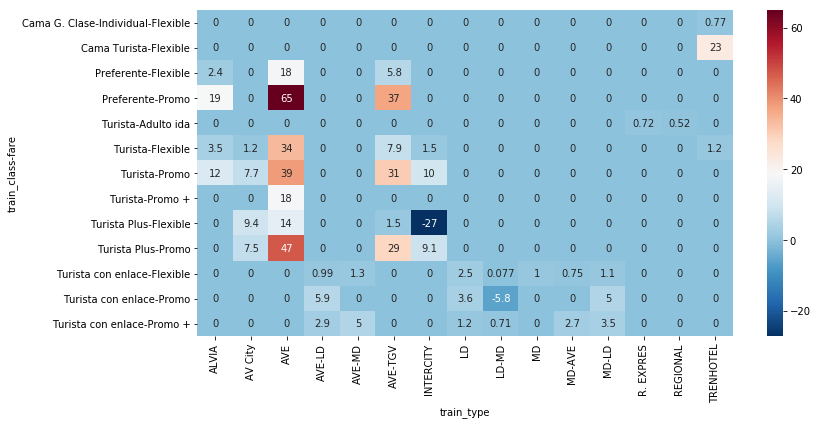

In [38]:
# Max price error (euros)

sns.heatmap(pd.pivot_table(data=test,
                           columns='train_type',
                           index=['train_class', 'fare'],
                           values='err',
                           fill_value=0,
                           aggfunc=np.max),
            annot=True, cmap="RdBu_r")

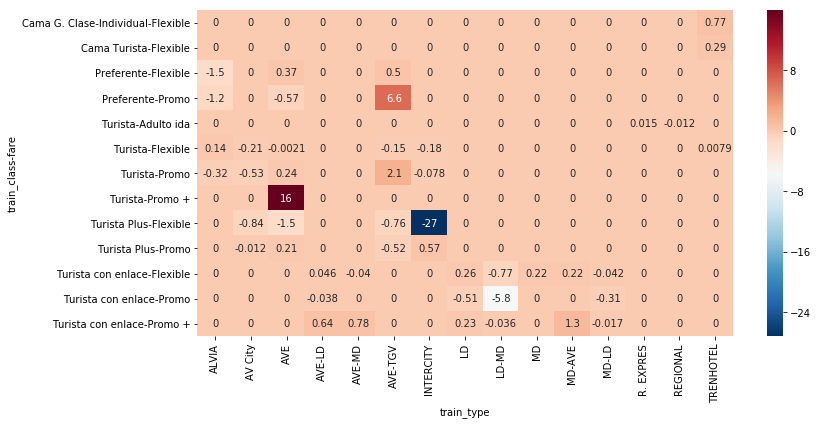

In [42]:
# Median price error (euros)

sns.heatmap(pd.pivot_table(data=test,
                           columns='train_type',
                           index=['train_class', 'fare'],
                           values='err',
                           fill_value=0,
                           aggfunc=np.median),
            annot=True, cmap="RdBu_r")

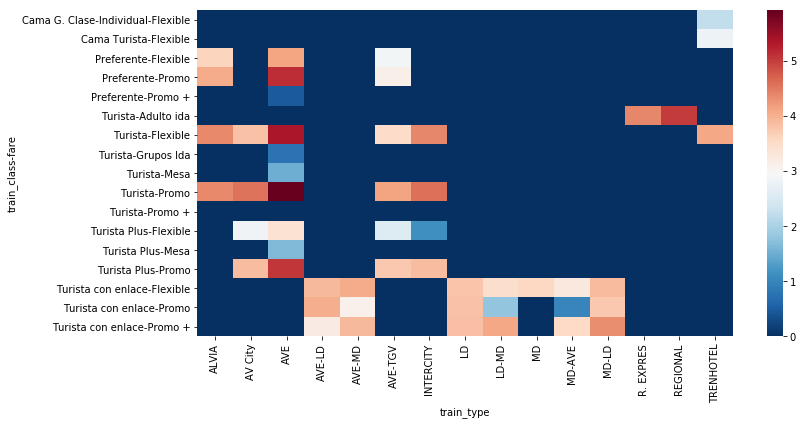

In [48]:
# Number of training rows (logarithmic scale)

sns.heatmap(pd.pivot_table(data=X_train,
                           columns='train_type',
                           index=['train_class', 'fare'],
                           values='route',
                           fill_value=0,
                           aggfunc=lambda x: np.log10(len(x))),
            annot=False, cmap="RdBu_r")

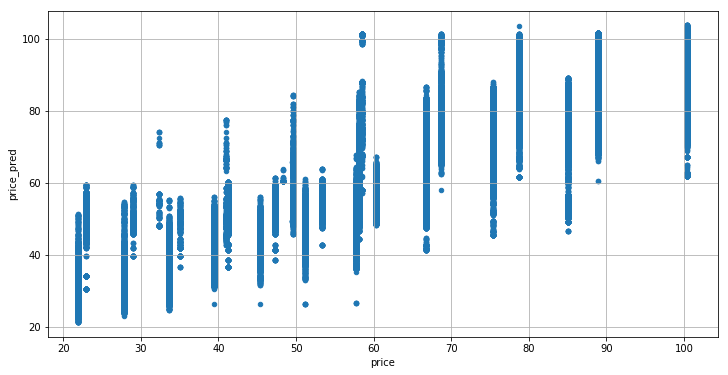

In [60]:
# Predictions for 'AVE' trains; 'Turista - Promo' fare class

test[(test.train_type=='AVE') &
     (test.train_class=='Turista') &
     (test.fare=='Promo')].plot.scatter(x='price', y='price_pred', marker='o')
plt.grid()

### Visual evaluation

In [18]:
def evaluate(i):
    df_test = df[df.test==True]
    df_test = df_test[(df_test.route_id == df_test.route_id.unique()[i])]
    df_test['price_pred'] = model.predict(df_test[['route', 'train_type', 'train_class', 'fare',
                                                   'trip_duration_hours', 'days_to_departure',
                                                   'departure_time', 'departure_hour', 'departure_dow']])

    figsize(12, 6)
    sns.scatterplot(data=df_test, x='days_to_departure', y='price', hue='fare_class')
    sns.scatterplot(data=df_test, x='days_to_departure', y='price_pred', color='.2', marker='.')
    plt.title(df_test.route_name.values[0])
    plt.grid()

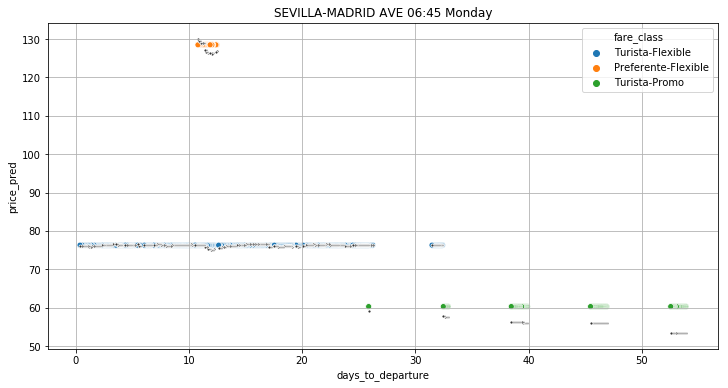

In [19]:
evaluate(0)

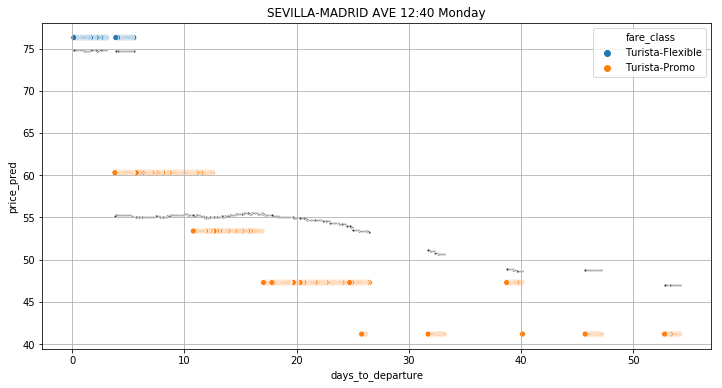

In [23]:
evaluate(4)

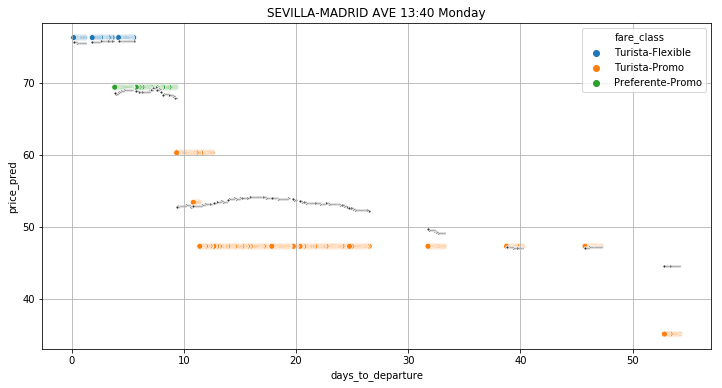

In [24]:
evaluate(5)